In [62]:
import numpy as np
from qutip import Options
import qutip as qt
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from tqdm import tqdm


opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive, Output

# Initial qubit frequencies and SNAIL frequency
freqs = np.array([4, 6, 4.665925])  # q1, q2, q3 frequencies
snail_freq = 5.6675931  # SNAIL frequency


# Adjust qubit frequencies based on a shrink factor
def adjust_frequencies(freqs, snail_freq, shrink_factor):
    # Combine the frequencies and the SNAIL frequency into one array
    all_freqs = np.append(freqs, snail_freq)

    # Calculate the midpoint of all frequencies including the SNAIL frequency
    midpoint = np.mean(all_freqs)

    # Translate all frequencies to the origin (midpoint becomes the new origin)
    translated_freqs = all_freqs - midpoint

    # Apply the shrink factor (scaling about the new origin)
    scaled_freqs = translated_freqs * shrink_factor

    # Translate all frequencies back to the original location
    adjusted_freqs = scaled_freqs + midpoint

    # Separate the qubit frequencies from the SNAIL frequency
    adjusted_qubit_freqs = adjusted_freqs[:-1]
    adjusted_snail_freq = adjusted_freqs[-1]

    return adjusted_qubit_freqs, adjusted_snail_freq

In [64]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

adjusted_freqs, adjusted_snail = adjust_frequencies(
    freqs, snail_freq, shrink_factor=1.0
)
adjusted_freqs, adjusted_snail

(array([5.06167, 4.54944, 4.16829]), 4.27515)

In [65]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=adjusted_freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=adjusted_freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=adjusted_freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=adjusted_snail, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [66]:
# Step 1. construct the linear Hamiltonian
HL = 0
# HL += snail.freq * qs.modes_num[snail]
# for q in qubits:
#     HL -= q.freq * (qs.modes_Z[q] / 2)
for m in qs.modes:
    HL += m.freq * qs.modes_num[m]

# Step 2. add the SNAIL non-linearity
HNL = snail.g3 / 6 * (qs.modes_field[snail]) ** 3
for q in qubits:
    HNL += q.alpha / 12 * (qs.modes_num[q]) ** 4

# Step 3. Add the coupling terms
Hc = 0
for c, g in qs.couplings.items():
    q1, q2 = c
    Hc += g * (qs.modes_field[q1] * qs.modes_field[q2])

# Total Hamiltonian
H0 = HL + HNL + Hc

# pump_term = qs.modes_a_dag[snail] - qs.modes_a[snail]
pump_term = qs.modes_a_dag[snail] + qs.modes_a[snail]
H1 = pump_term

In [67]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])

# search for dressed initial state using the eigenstates of the Hamiltonian
eigenvalues, eigenvectors = H0.eigenstates()
for eigen_index, eigenvector in enumerate(eigenvectors):
    overlap = np.abs(eigenvector.overlap(psi0))
    if overlap > 0.95:
        break
print(f"Found overlap with eigenstate {eigen_index} by {overlap:.4f}")
psi0 = eigenvectors[eigen_index]

# convert to density matrix
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate 3 by 0.9954


In [68]:
desired_U = qt.qip.operations.iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

expected_rho = qt.Qobj(desired_U * rho0 * desired_U.dag())

In [69]:
# (dressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
# c_ops.append(mode.collapse_operators(qs))

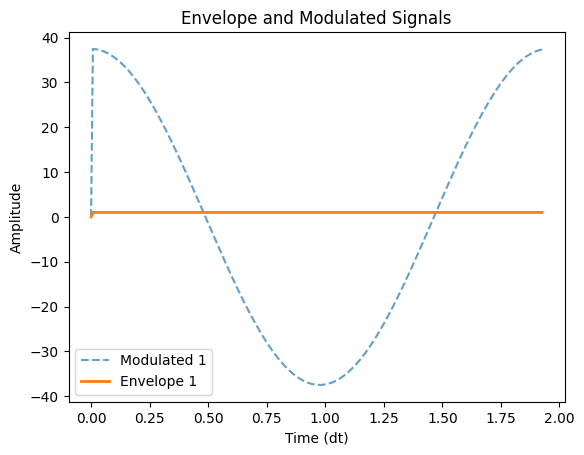

In [70]:
# Step 3. construct the pump term
# Experiment constants
width_d = 500  # in ns
N = 15
detuning_range = (-0.005, 0.005)  # in GHz
amp_range = (25, 50)
# Convert GHz to MHz
detuning_flist = np.linspace(detuning_range[0], detuning_range[1], N) * 1000
# Conversion to radian frequency
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(qubit1.freq - qubit2.freq)
alist = np.linspace(amp_range[0], amp_range[1], N)
t_list = np.linspace(0, 20 + width_d, 1000)  # Time vector for simulations

t0 = 0
args = {"shape": Pulse.box, "shape_params": {"t0": t0, "width": width_d}}

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)
Pulse.plot_pulse([(pulse, args)], period_time)

In [71]:
# Constants and parameters
T, wp, c = 500, 3.2633, 8.5714

# change T to be a single period of the pulse
T = 2 * np.pi / wp

# # Calculate the propagator for T
# # assumes Ampltiude * envelope(t) is real/constant

# # v1 integrate Pulse H1(t) = [c e^{-iwt} - c^* e^{iwt}] from 0 to T
# U_t = (-1j * (H0 * T + H1 * (2 * c * 1j * (np.cos(wp * T) - 1) / wp))).expm()

# v2 integate the Pulse H1(t) = c * cos(wp * t) from 0 to T
# U_t = (-1j * (H0 * T + H1 * (c * np.sin(wp * T) / wp))).expm()
# # Apply the propagator to the initial state
# rho_t = qt.Qobj(U_t * rho0 * U_t.dag())

# # Calculate fidelities
# best_fidelity = qt.fidelity(rho_t, expected_rho)
# avg_gate_fidelity = qt.average_gate_fidelity(desired_U, U_t)
# print(f"Best fidelity: {best_fidelity:.4f} with c = {c:.4f}")
# print(f"Average gate fidelity: {avg_gate_fidelity:.4f}")

#####################################
# try using qutip's propagator
# turns out to be the same as our manual integral calculation
period_time = np.linspace(0, T, 250)  # a single period of the pulse
pulse = Pulse(omega=wp, amp=c)
H = [H0, [H1, pulse.drive]]
U_ts = qt.propagator(H, period_time, c_ops, args=args, options=opts)

# plot occupations for each time step inside the period
period_occupations = {mode: np.zeros(len(period_time)) for mode in qs.modes_num}
for idx, t in enumerate(period_time):
    rho_tt = qt.Qobj(U_ts[idx] * rho0 * U_ts[idx].dag())
    for mode in qs.modes_num:
        period_occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

# next, propagate the state 1 period at a time
U_t = U_ts[-1]  # propagator for T=1 period
full_time = np.linspace(0, 250 * T, 250)  # 250 periods of the pulse
occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}

rho_tt = rho0
for idx, t in tqdm(enumerate(full_time)):
    rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
    for mode in qs.modes_num:
        # cast to reals, but we expect the imaginary part to be zero
        occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

250it [00:01, 225.33it/s]


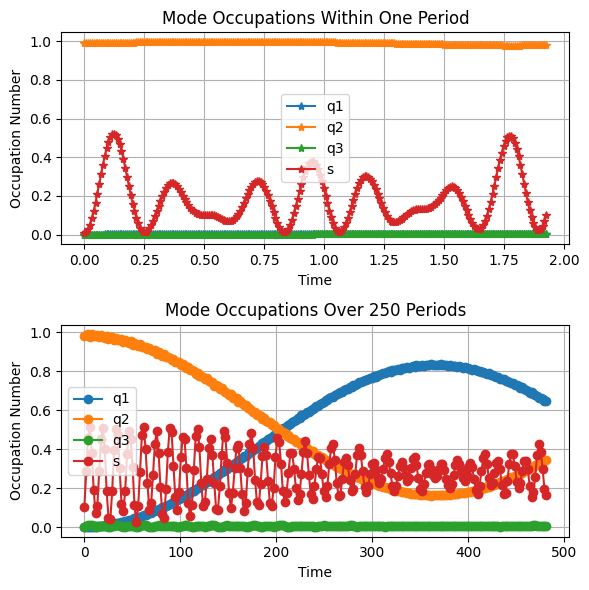

In [72]:
# Assuming qs.modes_num and other variables are already defined and calculated

# Setup the figure and axes for subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plotting fine-grained evolution within one period
for mode, occ in period_occupations.items():
    axs[0].plot(period_time, occ, label=mode.name, marker="*")
axs[0].set_title("Mode Occupations Within One Period")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Occupation Number")
axs[0].legend()
axs[0].grid(True)

# Plotting full time evolution over 20 periods
for mode, occ in occupations.items():
    axs[1].plot(full_time, occ, label=mode.name, marker="o")
axs[1].set_title("Mode Occupations Over 250 Periods")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Occupation Number")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [47]:
def simulation_task(params):
    freq, amp = params
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [pump_term, pulse.drive]
    H = [H0, H_pump]
    solve_result = qt.mesolve(H, psi0, t_list, c_ops, args=args, options=opts)
    final_state = solve_result.states[-1]
    fidelity = qt.fidelity(expected_rho, final_state)
    return freq, amp, fidelity

In [48]:
# Preparing frequency-amplitude pairs
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

10.2%. Run time: 140.61s. Est. time left: 00:00:20:34
20.0%. Run time: 269.64s. Est. time left: 00:00:17:58
30.2%. Run time: 390.61s. Est. time left: 00:00:15:01
40.0%. Run time: 513.63s. Est. time left: 00:00:12:50
50.2%. Run time: 638.51s. Est. time left: 00:00:10:32
60.0%. Run time: 764.24s. Est. time left: 00:00:08:29
70.2%. Run time: 895.69s. Est. time left: 00:00:06:19
80.0%. Run time: 1071.97s. Est. time left: 00:00:04:27
90.2%. Run time: 1233.16s. Est. time left: 00:00:02:13
100.0%. Run time: 1385.58s. Est. time left: 00:00:00:00
Total run time: 1385.65s


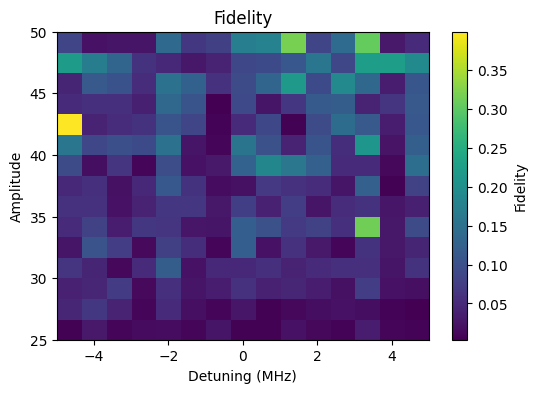

Max fidelity: 0.3994 at Frequency: 3.1870 GHz and Amplitude: 42.8571


In [49]:
# Initialize the fidelity matrix
fidelity_matrix = np.zeros((N, N))

# Fill the fidelity matrix with results
for freq, amp, fidelity in results:
    freq_idx = np.searchsorted(flist, freq)
    amp_idx = np.searchsorted(alist, amp)
    fidelity_matrix[amp_idx, freq_idx] = fidelity

# Plotting fidelity
fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.imshow(
    fidelity_matrix,
    interpolation="nearest",
    cmap="viridis",
    extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
    origin="lower",
    aspect="auto",
)
ax.set_title("Fidelity")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Amplitude")
fig.colorbar(cax, label="Fidelity")
plt.show()

# Identifying optimal parameters for maximum fidelity
max_fid_idx = np.unravel_index(
    np.argmax(fidelity_matrix, axis=None), fidelity_matrix.shape
)

max_fidelity_amp = alist[max_fid_idx[0]]
max_fidelity_freq = flist[max_fid_idx[1]]

print(
    f"Max fidelity: {fidelity_matrix[max_fid_idx]:.4f} at Frequency: {max_fidelity_freq:.4f} GHz and Amplitude: {max_fidelity_amp:.4f}"
)

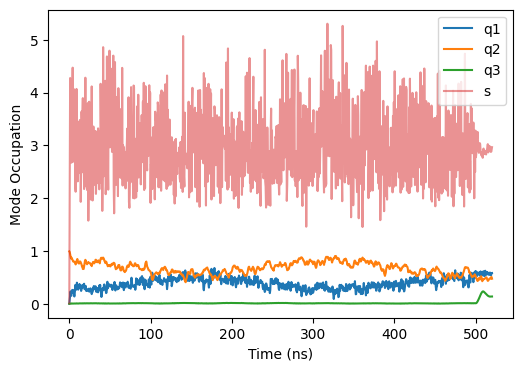

In [50]:
# Rerun the simulation with the optimal parameters
pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
H_pump = [pump_term, pulse.drive]
H = [H0, H_pump]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(qs.modes):
    ax.plot(
        t_list, solve_result.expect[k], label=mode.name, alpha=(0.5 if k == 3 else 1)
    )
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()